<a href="https://colab.research.google.com/github/Julianpucheta/OptimalControl/blob/main/Example_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
!apt install octave

Reading package lists... Done
Building dependency tree       
Reading state information... Done
octave is already the newest version (4.2.2-1ubuntu1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [12]:
!apt-get update

Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:6 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Reading package lists... Done


In [59]:
%%writefile Controlador.m
%Example extracted from: Sontag. Mathematical control theory 1998. Pag 104. http://www.sontaglab.org.
clc;clear all; clc;clear all;%close all;
m=.1;Fricc=0.1; long=0.6;g=9.8;M=.5;
h=0.001;tiempo=(20/h);p_pp=0;tita_pp=0; t=0:h:tiempo*h;
%Condiciones iniciales
% alfa(1)=.5; color='.g';
%alfa(1)=.97; color='b';
alfa(1)=-3.14; color='r';
ref=0;
omega(1)=0; p_p(1)=0; u(1)=0; p(1)=0; i=1;indice=0;
%Versión linealizada en el equilibrio inestable. Sontag Pp 104.
% estado=[p(i); p_p(i); alfa(i); omega(i)]
Mat_A=[0 1 0 0;0 -Fricc/M -m*g/M 0; 0 0 0 1; 0 Fricc/(long*M) g*(m+M)/(long*M) 0];
Mat_B=[0; 1/M; 0; -1/(long*M)];
Mat_C=[1 0 0 0;0 0 1 0]; %La salida multivariable es posicion y angulo
Mat_M=[Mat_B Mat_A*Mat_B Mat_A^2*Mat_B Mat_A^3*Mat_B];%Matriz Controlabilidad
auto_val=eig(Mat_A);
c_ai=conv(conv(conv([1 -auto_val(1)],[1 -auto_val(2)]),[1 -auto_val(3)]),[1 -auto_val(4)]); %= poly(eig(Mat_A))
Mat_W=[c_ai(4) c_ai(3) c_ai(2) 1;c_ai(3) c_ai(2) 1 0;c_ai(2) 1 0 0;1 0 0 0];
Mat_T=Mat_M*Mat_W;% T=Q=Co*Toeplitz
A_controlable=inv(Mat_T)*Mat_A*Mat_T; %Verificaci?n de que T est? bien
B_controlable=inv(Mat_T)*Mat_B; %Verificaci?n de que T est? bien
C_controlable=Mat_C*(Mat_T); %Verificaci?n de que T est? bien
a4=-A_controlable(4,1); %a4
a3=-A_controlable(4,2);  
a2=-A_controlable(4,3);
a1=-A_controlable(4,4); %q4=10000; %  q3=100000;q2=100;q1=1; R=10 anda con 3.14
q4=100000;
q3=1000000;
q2=10000;
q1=1000;
Q=diag([q1 q2 q3 q4]);
R=10 ;%1e-1;
p1=.5*(-4*a4*R+sqrt((4*a4*R)^2+16*q1*R));
p2=.5*(-4*a3*R+sqrt((4*a3*R)^2+16*q2*R));
p3=.5*(-4*a2*R+sqrt((4*a2*R)^2+16*q3*R));
p4=.5*(-3*a1*R+sqrt((3*a1*R)^2+8*q4*R));
P=diag([p1 p2 p3 p4]);
P(4,:)=[p1 p2 p3 p4]; %K=(([p1 p2 p3 p4])/(2*R))*inv(Mat_T);
%K=[p1 p2 p3 p4]/(2*R);
K=(1/(2*R))*[0 0 0 1]*P*inv(Mat_T);  %%  -0.3162   -1.2799  -82.3027  -22.5112
disp('Closed-loop poles for the controller:')
eig(Mat_A-Mat_B*K)
%Observer:
%Dual
Mat_Adual=Mat_A';
Mat_Bdual=Mat_C';
Mat_Cdual=Mat_B';
Qdual=diag([1 1 1 10000]);Rdual= 0.01*eye(2) ;%1e4*eye(2); %q4=100000;q3=1000000;q2=10000; q1=1000;
% Ko = lqr(Mat_Adual,Mat_Bdual,Qdual,Rdual)';
Ha=[Mat_Adual -Mat_Bdual*inv(Rdual)*Mat_Bdual'; -Qdual -Mat_Adual'];
[n,va]=size(Ha);
[V,D]=eig(Ha);MX1X2=[];
for ii=1:n
    if real(D(ii,ii))<0
        MX1X2=[MX1X2 V(:,ii)];
    end
end
MX1=MX1X2(1:n/2,:); MX2=MX1X2(n/2+1:end,:);
P=real(MX2*inv(MX1));
Ko=(inv(Rdual)*Mat_Bdual'*P)';
disp('Closed-loop poles for the observer:')
eig(Mat_A-Ko*Mat_C)
x_hat=[0 0 0 0]';Jn(1)=0;
T_CI=4;
Mat_datop=zeros(2,tiempo+1);
Mat_datop_p=zeros(2,tiempo+1);
Mat_datoalfa=zeros(2,tiempo+1);
Mat_datoomega=zeros(2,tiempo+1);
Mat_datou=zeros(2,tiempo+1);
hfig2 = figure(2); set(hfig2, 'Visible', 'off');hold on;
for ci =1:T_CI
    x_hat=[0 0 0 0]';Jn(1)=0;
    ref=0;
    omega(1)=0; p_p(1)=0; u(1)=0; p(1)=0; i=1;indice=0;
    switch (ci)
        case 1
            alfa(1)=-pi;color='k';
        case 2
            alfa(1)=.6;color='r';
        case 3
            alfa(1)=-.6;color='g';
        case 4
            alfa(1)=pi;color='b';        
    end
    Mat_datop(ci,1)=p(1);
    Mat_datop_p(ci,1)=p_p(1);
    Mat_datoalfa(ci,1)=alfa(1);
    Mat_datoomega(ci,1)=omega(1);
    Mat_datou(ci,1)=u(1);
    while(i<(tiempo+1))
        estado=[p(i); p_p(i); alfa(i); omega(i)];
        %      u(i)=-K*estado;
        u(i)=-K*x_hat;
        % u(i)=max(-200,u(i));
        % u(i)=min(200,u(i));
        p_pp=(1/(M+m))*(u(i)-m*long*tita_pp*cos(alfa(i))+m*long*omega(i)^2*sin(alfa(i))-Fricc*p_p(i));
        tita_pp=(1/long)*(g*sin(alfa(i))-p_pp*cos(alfa(i)));
        p_p(i+1)=p_p(i)+h*p_pp;
        p(i+1)=p(i)+h*p_p(i);
        omega(i+1)=omega(i)+h*tita_pp;
        alfa(i+1)=alfa(i)+h*omega(i);
        Y=Mat_C*estado;
        y_sal(i)=Y(1);
        %________OBSERVADOR__________
        Yest=Mat_C*x_hat;
        y_sal_O(i)=Yest(1);
        x_hatp=Mat_A*x_hat+Mat_B*u(i)+Ko*(Y-Yest);
        x_hat=x_hat+h*x_hatp;
        Jn(i+1)=Jn(i)+x_hat'*Q*x_hat+u(i)'*R*u(i);        
        i=i+1;
    end    
    u(i)=-K*estado;
    %     Mat_dato=zeros(2,4+1,tiempo+1);
    Mat_datop(ci,:)=p;
    Mat_datop_p(ci,:)=p_p;
    Mat_datoalfa(ci,:)=alfa;
    Mat_datoomeaga(ci,:)=omega;
    Mat_datou(ci,:)=u;
    subplot(2,2,1);plot(alfa,omega,color);grid on;xlabel('Angle');ylabel('Angle velocity');hold on;
    subplot(2,2,2);plot(p,p_p,color);grid on;xlabel('Cart position');ylabel('Cart velocity');hold on;
end
print(hfig2,'Pendulo_fase','-dpng');
hfig1 = figure(1); set(hfig1, 'Visible', 'off');
subplot(3,2,1);plot(t,Mat_datop);grid on; title('Cart position');hold on;
subplot(3,2,2);plot(t,Mat_datoalfa);grid on;title('Angle');hold on;
subplot(3,2,3); plot(t,Mat_datop_p);grid on;title('Cart velocity');hold on;
subplot(3,2,4);plot(t,Mat_datoomega);grid on;title('Angle velocity');hold on;
subplot(3,1,3);plot(t,Mat_datou);grid on;title('Force action');xlabel('Time Sec.');hold on;
print(hfig1,'Pendulo_t','-dpng');
save('Datos_Controlador.mat','-v7')

Overwriting Controlador.m


In [60]:
# -W : no window system
!octave -W Controlador.m
import scipy.io
mat = scipy.io.loadmat('/content/Datos_Controlador.mat')


Closed-loop poles for the controller:
ans =

  -65.96504 +  0.00000i
   -4.70062 +  0.00000i
   -0.04759 +  0.17316i
   -0.04759 -  0.17316i

Closed-loop poles for the observer:
ans =

   -1.0440 +  0.0000i
   -9.9474 +  0.0000i
  -23.1278 + 21.5707i
  -23.1278 - 21.5707i

Some output formats are not available.
    __print_parse_opts__ at line 388 column 9
    print at line 316 column 8
    Controlador at line 123 column 1


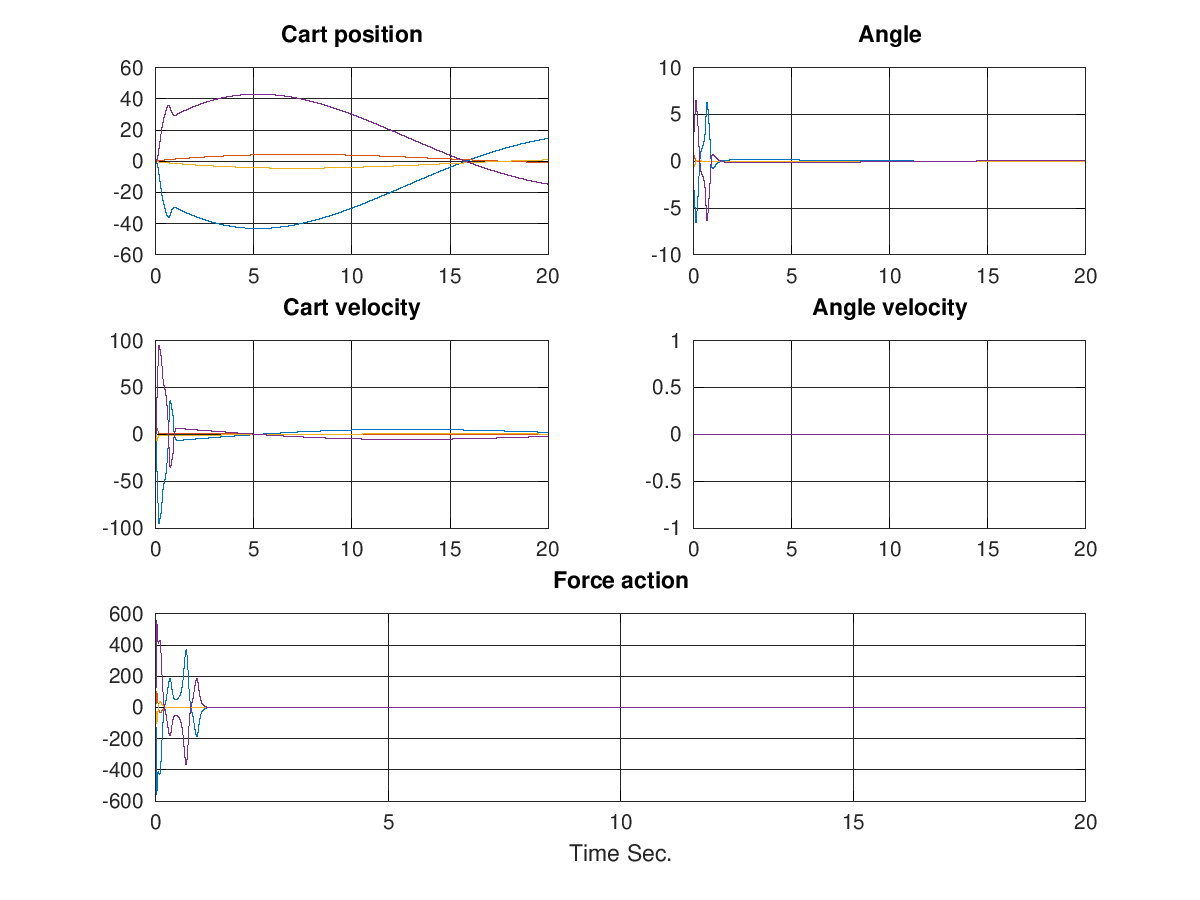

In [61]:
from PIL import Image
imt = Image.open("/content/Pendulo_t.png")

imt


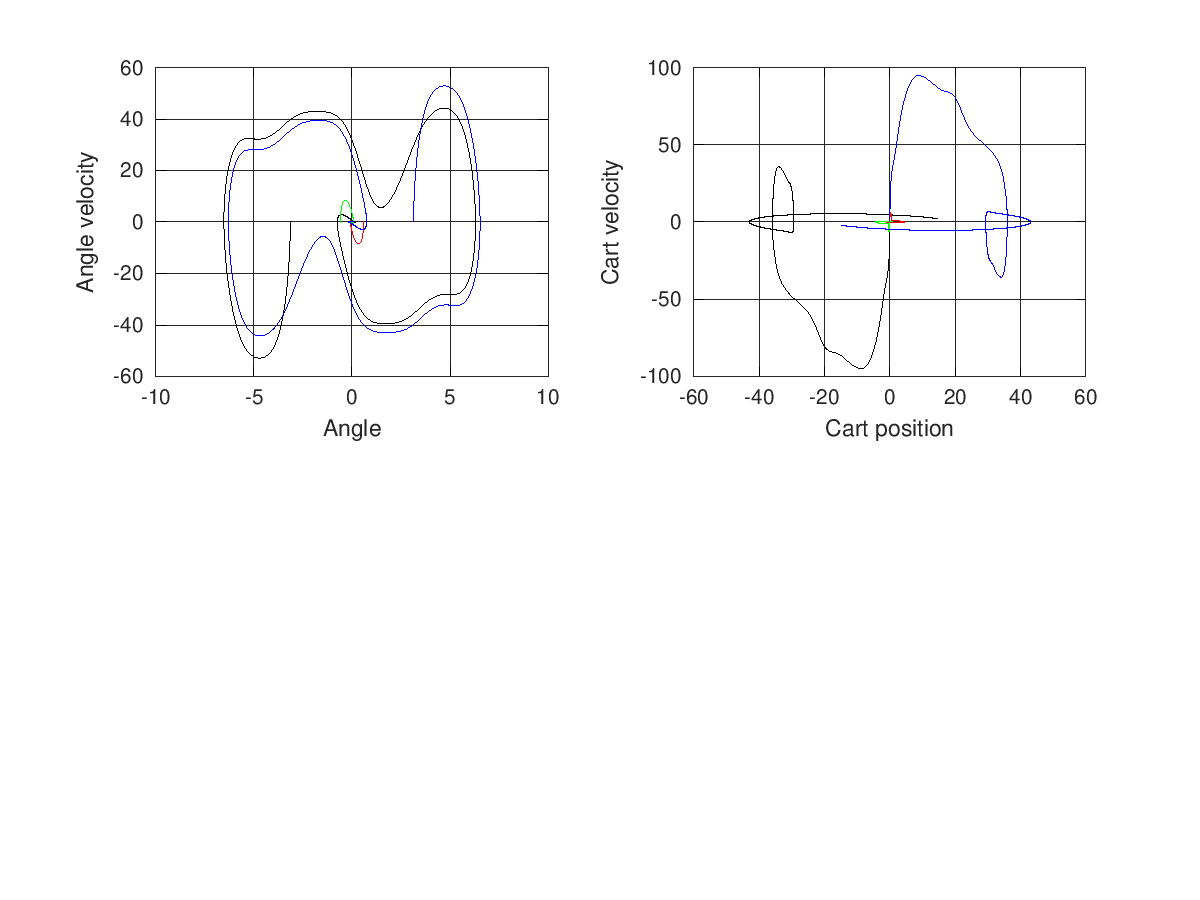

In [62]:
imf = Image.open("/content/Pendulo_fase.png")

imf